In [2]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
import numpy as np
import matplotlib.pyplot as plt
from BEAR.Utils.utils_building import ParameterGenerator
from BEAR.Env.env_building import BuildingEnvReal

In [3]:
Parameter = ParameterGenerator(
    'OfficeSmall',
    'Hot_Dry',
    'Tucson',
    root='/Users/Mo/Desktop/BEAR/BEAR/Data/'   
)
vec_env = make_vec_env(lambda: BuildingEnvReal(Parameter), n_envs=1)


###############All Zones from Ground############
CORE_ZN  [Zone index]:  0
PERIMETER_ZN_1  [Zone index]:  1
PERIMETER_ZN_2  [Zone index]:  2
PERIMETER_ZN_3  [Zone index]:  3
PERIMETER_ZN_4  [Zone index]:  4
ATTIC  [Zone index]:  5
###################################################


In [4]:
model = PPO(
        policy="MlpPolicy",
        env=vec_env,
        verbose=1,
        learning_rate=3e-4,
        n_steps=4096,
        ent_coef=0.01,
        clip_range=0.2,
        n_epochs=10
    )
print("模型动作空间:", model.action_space)
print("模型观察空间:", model.observation_space)

Using cpu device
模型动作空间: Box(-1.0, 1.0, (6,), float32)
模型观察空间: Box([-40.        -40.        -40.        -40.        -40.        -40.
 -40.          0.          0.          0.          0.          0.
   0.        -40.          0.2855729   0.2855729   0.2855729   0.2855729
   0.2855729   0.2855729], [  40.   40.   40.   40.   40.   40.   40. 1000. 1000. 1000. 1000. 1000.
 1000.   40. 1000. 1000. 1000. 1000. 1000. 1000.], (20,), float32)


In [20]:
model.learn(
    total_timesteps=500000,
    log_interval=100
)
model.save("PPO_myquick_trained")

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 8.76e+03    |
|    ep_rew_mean          | -1.66e+05   |
| time/                   |             |
|    fps                  | 2740        |
|    iterations           | 100         |
|    time_elapsed         | 149         |
|    total_timesteps      | 409600      |
| train/                  |             |
|    approx_kl            | 0.028618364 |
|    clip_fraction        | 0.229       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0603     |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 101         |
|    n_updates            | 990         |
|    policy_gradient_loss | -0.00664    |
|    std                  | 0.25        |
|    value_loss           | 2.53e+03    |
-----------------------------------------


In [7]:
model = PPO.load("PPO_myquick_trained.zip")

In [8]:
obs = vec_env.reset() #状态
rewardlist = []
statelist = []
actionlist = []

for i in range(24):
    action, _states = model.predict(obs) #当前状态下的最优动作
    obs, rewards, dones, info = vec_env.step(action) #动作和环境交互一步，得到新状态和奖励
    statelist.append(obs.copy())
    actionlist.append(action.copy())
    rewardlist.append(rewards)

print(f"已收集 {len(statelist)}，{len(actionlist)}，{len(rewardlist)} 奖励数据")

已收集 24 条状态，24 条动作，24 条奖励数据


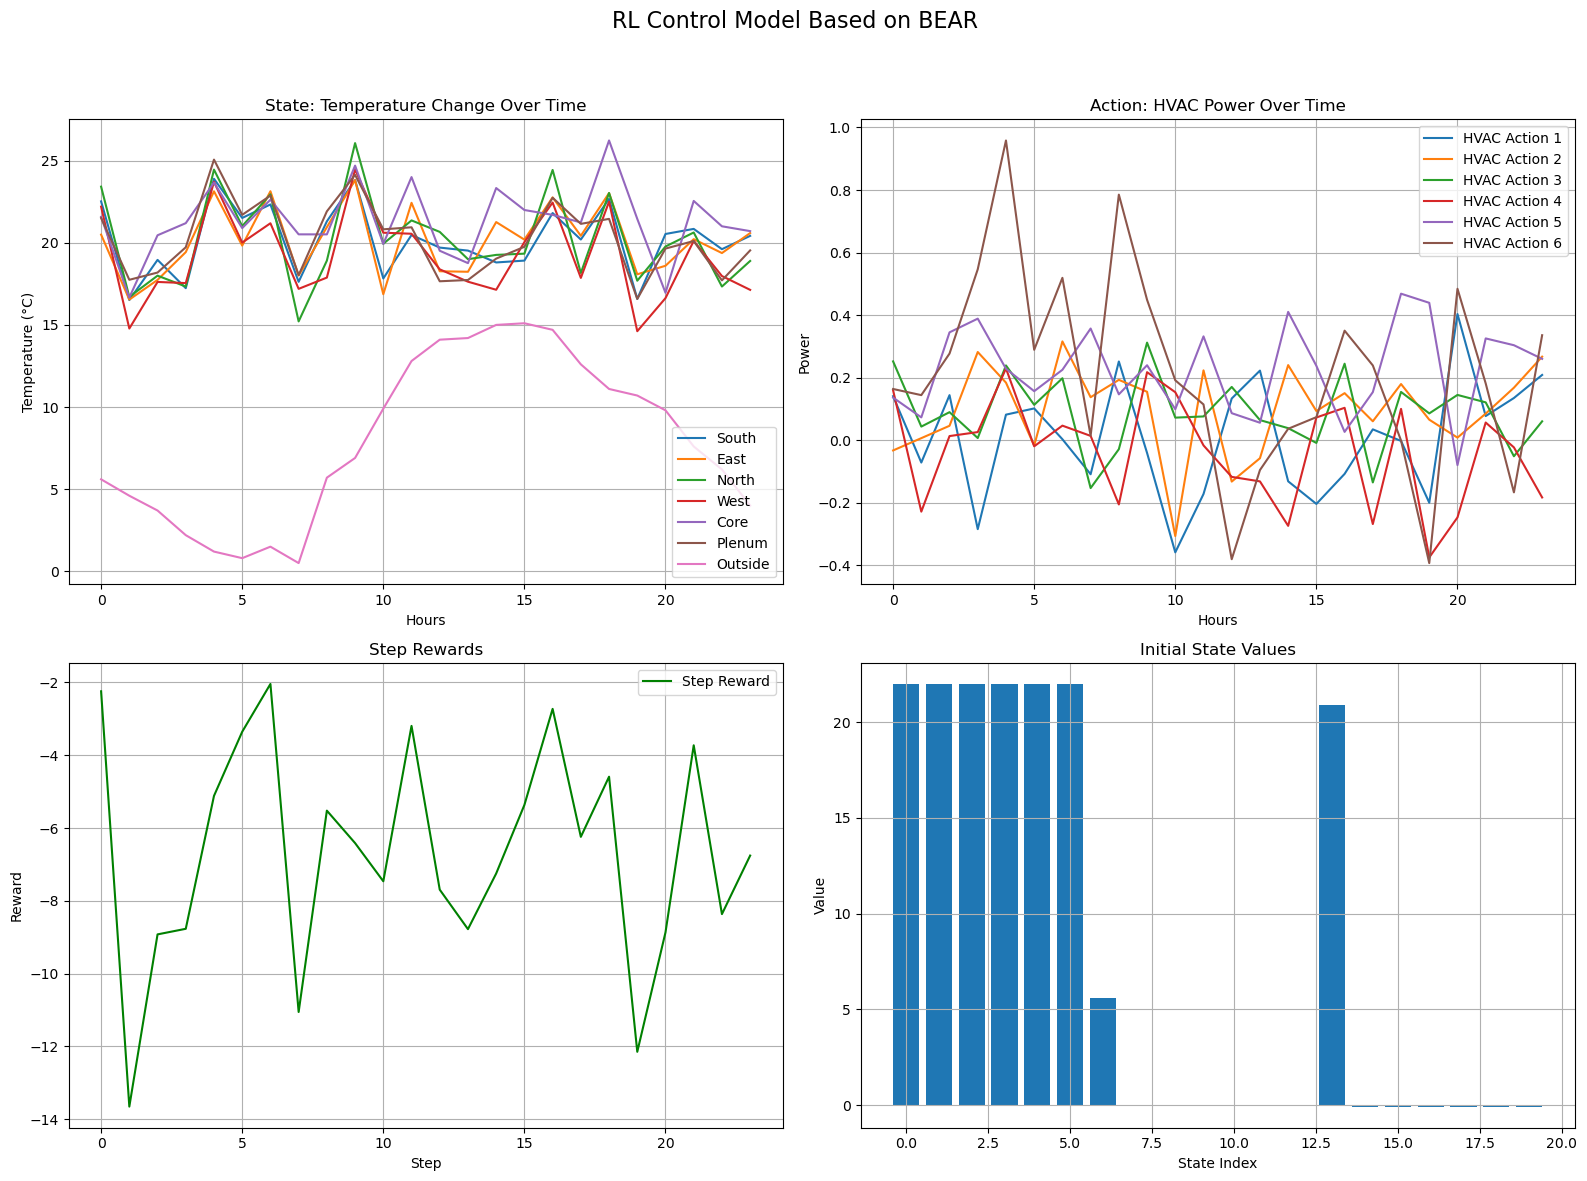

In [9]:
temperature_data = np.array(statelist).squeeze()
action_data = np.array(actionlist).squeeze() if len(actionlist) > 0 else None
reward_data = np.array(rewardlist).squeeze() if len(rewardlist) > 0 else None

fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('RL Control Model Based on BEAR', fontsize=16)

# 温度变化曲线
axs[0, 0].plot(temperature_data[:, :7])
axs[0, 0].set_title('State: Temperature Change Over Time')
axs[0, 0].set_xlabel('Hours')
axs[0, 0].set_ylabel('Temperature (°C)')
axs[0, 0].legend(['South', 'East', 'North', 'West', 'Core', 'Plenum', 'Outside'], loc='lower right')
axs[0, 0].grid(True)

# 动作HVAC功率）
if action_data is not None:
    if len(action_data.shape) == 1:
        axs[0, 1].plot(action_data, label='HVAC Action')
    else:
        for i in range(action_data.shape[1]):
            axs[0, 1].plot(action_data[:, i], label=f'HVAC Action {i+1}')
    axs[0, 1].set_title('Action: HVAC Power Over Time')
    axs[0, 1].set_xlabel('Hours')
    axs[0, 1].set_ylabel('Power')
    axs[0, 1].legend()
    axs[0, 1].grid(True)
else:
    fig.delaxes(axs[0, 1])
    print("actionlist空")

# 奖励变化曲线
if reward_data is not None:
    axs[1, 0].plot(reward_data, color='green', label='Step Reward')
    axs[1, 0].set_title('Step Rewards')
    axs[1, 0].set_xlabel('Step')
    axs[1, 0].set_ylabel('Reward')
    axs[1, 0].legend()
    axs[1, 0].grid(True)
else:
    fig.delaxes(axs[1, 0])
    print("rewardlist空")

# 初始状态柱状图
try:
    initial_state = vec_env.reset()
    axs[1, 1].bar(range(len(initial_state[0])), initial_state[0])
    axs[1, 1].set_title('Initial State Values')
    axs[1, 1].set_xlabel('State Index')
    axs[1, 1].set_ylabel('Value')
    axs[1, 1].grid(True)
except Exception as e:
    fig.delaxes(axs[1, 1])
    print(f"{e}")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



In [11]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
import json
import os

# 你的 BEAR 环境代码
from BEAR.Env.env_building import BuildingEnvReal
from BEAR.Utils.utils_building import ParameterGenerator

params = ParameterGenerator("OfficeSmall", "Hot_Dry", "Tucson")
env = BuildingEnvReal(params)


###############All Zones from Ground############
CORE_ZN  [Zone index]:  0
PERIMETER_ZN_1  [Zone index]:  1
PERIMETER_ZN_2  [Zone index]:  2
PERIMETER_ZN_3  [Zone index]:  3
PERIMETER_ZN_4  [Zone index]:  4
ATTIC  [Zone index]:  5
###################################################


In [16]:
class TrajectoryRecorder(BaseCallback):
    def __init__(self, save_path="ppo_trajectory.json", verbose=0):
        super().__init__(verbose)
        self.trajectory = []
        self.save_path = save_path
        self.last_obs = None  # 当前 observation

    def _on_rollout_start(self):
        self.last_obs = self.training_env.get_attr("state")[0]  # 记录 rollout 起始 obs

    def _on_step(self) -> bool:
        # 获取当前 obs（也就是 next_obs），与上一步 action、reward 组合成数据
        current_obs = self.training_env.get_attr("state")[0]  

        action = self.model.last_action if hasattr(self.model, "last_action") else [0]
        reward = float(self.locals["rewards"])
        done = bool(self.locals["dones"])

        self.trajectory.append({
            "obs": self.last_obs.tolist(),
            "action": action if isinstance(action, list) else action.tolist(),
            "reward": reward,
            "next_obs": current_obs.tolist(),
            "done": done
        })

        self.last_obs = current_obs  # 更新obs
        return True

    def _on_training_end(self) -> None:
        with open(self.save_path, "w") as f:
            json.dump(self.trajectory, f, indent=2)
        print(f"{self.save_path}")



In [17]:
model = PPO("MlpPolicy", env, verbose=1)
callback = TrajectoryRecorder(save_path="ppo_trajectory.json")
model.learn(total_timesteps=50000, callback=callback)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/var/folders/wp/l8c79r0x3rd_31sm3pkk2ccc0000gn/T/ipykernel_44536/1498358978.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reward = float(self.locals["rewards"])


-----------------------------
| time/              |      |
|    fps             | 4679 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 3011        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013802099 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.52       |
|    explained_variance   | -0.000777   |
|    learning_rate        | 0.0003      |
|    loss                 | 1.67e+05    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0268     |
|    std                  | 1           |
|    value_loss           | 3.11e+05    |
----------------------------------